<a href="https://colab.research.google.com/github/fsemecurbe/MMTMSS/blob/main/MMTMSS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multivariate Multifractals To Modelize Spatial Segregation

In [1]:
import pandas as pd
import numpy as np
rng = np.random.default_rng()
import matplotlib.pyplot as plt
import matplotlib as mpl
from skimage.measure import block_reduce

## Functions

In [2]:
def multivariate_lognormal_cascade(n, sigma1=1, sigma2=1, corr=0):
    mu1 = -1/2 * sigma1**2
    mu2 = -1/2 * sigma2**2

    PQ = np.exp(rng.multivariate_normal(np.array([mu1,mu2]),  np.array([[sigma1**2,corr*sigma1*sigma2], [corr*sigma1*sigma2, sigma2**2]]), 4))

    P = PQ[:,0].reshape(2,2)
    Q = PQ[:,1].reshape(2,2)
    for i in range(n):
        PQ = np.exp(rng.multivariate_normal(np.array([mu1,mu2]),np.array([[sigma1**2,corr*sigma1*sigma2], [corr*sigma1*sigma2, sigma2**2]]), P.shape[0]**2 * 4))
        P = np.kron(P, np.ones((2,2)))
        P = P * PQ[:,0].reshape(P.shape)
        Q = np.kron(Q, np.ones((2,2)))
        Q = Q * PQ[:,1].reshape(P.shape)

    P = P / np.sum(P)
    Q = Q / np.sum(Q)
    return(np.stack([P,Q], axis=-1))

def Theil(test):
  tp = test.sum(axis=2)
  prob = test[:,:,:] / tp[:,:, np.newaxis]
  ep = np.sum(-np.log2(prob) * prob, axis=2)
  e = (ep * tp / tp.sum()).sum()
  PROB =  test.sum(axis=(0,1)) / test.sum()
  E = -np.sum(PROB * np.log2(PROB))
  return(1 - (e/E))

#### Test de la fonction multivariate_lognormal_cascade

In [3]:
lnc = multivariate_lognormal_cascade(6, sigma1=0.178**0.5, sigma2=0.309**0.5, corr=-.185)
ratio = .2 * lnc[:,:,0] / (.2 * lnc[:,:,0] + .8 * lnc[:,:,1]) * 100

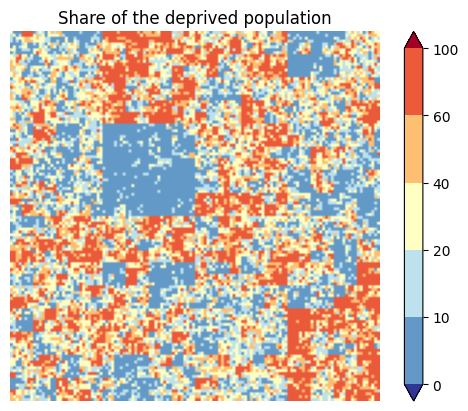

In [4]:
cmap = mpl.cm.RdYlBu_r
bounds = [0, 10, 20, 40, 60, 100]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')
mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots()
ax.set_axis_off();
ax.set_title('Share of the deprived population');
ax.imshow(cmap(norm(ratio)))
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),ax=ax);

### Calcul d'entropie

In [ ]:
lnc = multivariate_lognormal_cascade(8, sigma1=.32, sigma2=.44, corr=-0.94)
pop = lnc[:,:,0]
pop = block_reduce(pop, block_size = (4,4), func = np.sum)

1.4362743270087697
1.2225676313693568
1.0169567023078776
0.7991459671016641


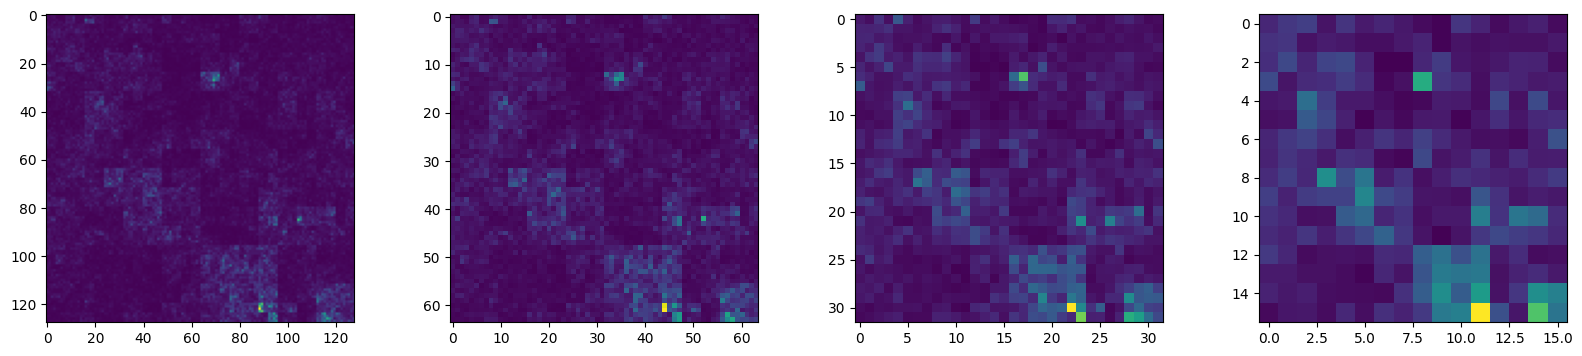

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4))
for i in range(4):
  small_arr = block_reduce(pop, block_size=(2**i,2**i), func=np.sum)
  axs[i].imshow(small_arr)
  print(np.var(np.log2(small_arr.flatten())))

(array([  1.,   1.,   1.,   3.,   9.,   9.,  24.,  35.,  59.,  79., 121.,
        172., 199., 273., 348., 477., 546., 604., 670., 782., 861., 896.,
        932., 971., 990., 971., 850., 833., 788., 687., 618., 530., 459.,
        420., 279., 232., 180., 140., 110.,  67.,  58.,  35.,  27.,  21.,
         10.,   2.,   1.,   0.,   2.,   1.]),
 array([-21.61620602, -21.34749472, -21.07878343, -20.81007214,
        -20.54136085, -20.27264955, -20.00393826, -19.73522697,
        -19.46651567, -19.19780438, -18.92909309, -18.6603818 ,
        -18.3916705 , -18.12295921, -17.85424792, -17.58553662,
        -17.31682533, -17.04811404, -16.77940275, -16.51069145,
        -16.24198016, -15.97326887, -15.70455757, -15.43584628,
        -15.16713499, -14.8984237 , -14.6297124 , -14.36100111,
        -14.09228982, -13.82357852, -13.55486723, -13.28615594,
        -13.01744465, -12.74873335, -12.48002206, -12.21131077,
        -11.94259947, -11.67388818, -11.40517689, -11.1364656 ,
        -10.867754

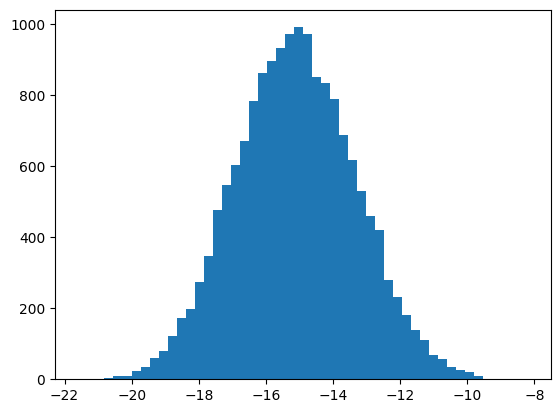

In [ ]:
plt.hist(np.log2(pop.flatten('F')), bins=100)

### Valeur de alpha pour alpha = 0 et la variance de la parabole

---



In [ ]:
sigma = 0.178**0.5
res = []
res2 = []
for i in range(10):
  lnc = multivariate_lognormal_cascade(10, sigma1=sigma, sigma2=.4, corr=.0)
  pop = block_reduce(lnc[:,:,0], block_size = (16,16), func = np.sum)
  entropies =  []
  entropies2 = []
  scales = np.array([i for i in range(1,4)])
  scales_exp2 = 2**scales
  for i in scales:
     small_arr = block_reduce(pop, block_size=(2**i,2**i), func=np.sum)
     entropies.append(-np.mean(np.log(small_arr)))
     entropies2.append(-np.var(np.log(small_arr)))
  entropies = np.array(entropies)
  entropies2 = np.array(entropies2)
  logscales = np.log(scales_exp2)
  res.append(-np.sum((entropies - entropies.mean()) * (logscales - logscales.mean())) / np.sum((logscales - logscales.mean())**2))
  res2.append(np.sum((entropies2 - entropies2.mean()) * (logscales - logscales.mean())) / np.sum((logscales - logscales.mean())**2))
np.mean(res), np.mean(res2)

(np.float64(2.12964476827898), np.float64(0.25654902843920857))

In [ ]:
2 + (sigma**2) / 2 / np.log(2)  , sigma**2   / np.log(2)

(np.float64(2.128399858639118), np.float64(0.2567997172782355))

### Valeur de f(alpha) = alpha pour alpha = 1

In [ ]:
sigma = 0.25

In [ ]:
res = []
for i in range(10):
  lnc = multivariate_lognormal_cascade(10, sigma1=sigma, sigma2=.4, corr=.0)
  pop = block_reduce(lnc[:,:,0], block_size = (16,16), func = np.sum)
  entropies =  []
  scales = np.array([i for i in range(1,4)])
  for i in scales:
     small_arr = block_reduce(pop, block_size=(2**i,2**i), func=np.sum)
     entropies.append(-np.sum(small_arr * np.log2(small_arr)))
  entropies = np.array(entropies)
  res.append(-np.sum((entropies - entropies.mean()) * (scales - scales.mean())) / np.sum((scales - scales.mean())**2))
np.mean(res)

np.float64(1.9535754387415245)

In [ ]:

mu = -1/2 * sigma**2 - np.log(4)

res = []
for i in range(10000000):
  samples = np.exp(np.random.normal(mu, sigma, size=4))
  #samples = samples / samples.sum()
  res.append(-np.sum(samples * np.log2(samples)))

print(np.mean(res))

1.9549133349221879


Vraie Valeur

In [ ]:
2 - ((sigma**2)/2 / np.log(2))

np.float64(1.9549157799722199)

### Calcul de la divergence

In [ ]:
sigma2

0.5744562646538028

In [ ]:
sigma1 = 0.178**0.5
sigma2 = 0.309**0.5
rho = -.185

In [ ]:
res = []
for i in range(10):
  lnc = multivariate_lognormal_cascade(10, sigma1=sigma1, sigma2=sigma2, corr=rho)
  pop1 = block_reduce(lnc[:,:,0], block_size = (16,16), func = np.sum)
  pop2 = block_reduce(lnc[:,:,1], block_size = (16,16), func = np.sum)
  entropies =  []
  scales = np.array([i for i in range(4)])
  for i in scales:
    small_arr1 = block_reduce(pop1, block_size=(2**i,2**i), func=np.sum)
    small_arr2 = block_reduce(pop2, block_size=(2**i,2**i), func=np.sum)
    entropies.append(np.sum(small_arr1 * np.log2(small_arr1/small_arr2)))
  entropies = np.array(entropies)
  res.append(-np.sum((entropies - entropies.mean()) * (scales - scales.mean())) / np.sum((scales - scales.mean())**2))
print(np.mean(res), + (sigma1**2+sigma2**2 - 2*rho*sigma1*sigma2) / np.log(2 ) / 2)

0.41490091734154155 0.4138906464022402


In [ ]:
(sigma1**2+sigma2**2 - 2*rho*sigma1*sigma2) / np.log(2 ) / 2

np.float64(0.4138906464022402)

### Application Paris

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
paris = np.load('drive/MyDrive/segregation/data/paris_household.npy')

In [ ]:
pop1 = paris[:,:,0]
pop2 = paris[:,:,1]
#pop2[(pop2<1) & (pop1>0)] = 1
pop1 = pop1 / pop1.sum()
pop2 = pop2 / pop2.sum()

In [ ]:
entropies1_1 =  []
entropies1_2 = []

entropies2_1 =  []
entropies2_2 = []

entropies_rho = []


scales = np.array([i for i in range(1,4)])
scales_exp2 = 2**scales
for i in scales:
  small_arr1 = block_reduce(pop1, block_size=(2**i,2**i), func=np.sum)
  small_arr2 = block_reduce(pop2, block_size=(2**i,2**i), func=np.sum)
  entropies1_1.append(-np.mean(np.log(small_arr1[small_arr1>0])))
  entropies1_2.append(-np.var(np.log(small_arr1[small_arr1>0])))
  entropies2_1.append(-np.mean(np.log(small_arr2[small_arr2>0])))
  entropies2_2.append(-np.var(np.log(small_arr2[small_arr2>0])))
  entropies_rho.append(np.sum(small_arr1[small_arr1>0] * np.log2(small_arr1[small_arr1>0]/small_arr2[small_arr1>0])))
entropies1_1 = np.array(entropies1_1)
entropies1_2 = np.array(entropies1_2)
entropies2_1 = np.array(entropies2_1)
entropies2_2 = np.array(entropies2_2)
entropies_rho = np.array(entropies_rho)

logscales = np.log(scales_exp2)


print(-np.sum((entropies1_1 - entropies1_1.mean()) * (logscales - logscales.mean())) / np.sum((logscales - logscales.mean())**2))
print(np.sum((entropies1_2 - entropies1_2.mean()) * (logscales - logscales.mean())) / np.sum((logscales - logscales.mean())**2) * np.log(2))

print(-np.sum((entropies2_1 - entropies1_1.mean()) * (logscales - logscales.mean())) / np.sum((logscales - logscales.mean())**2))
print(np.sum((entropies2_2 - entropies1_2.mean()) * (logscales - logscales.mean())) / np.sum((logscales - logscales.mean())**2) * np.log(2))

print(-np.sum((entropies_rho - entropies_rho.mean()) * (scales - scales.mean())) / np.sum((scales - scales.mean())**2))

2.1320231971813017
0.17712140753593963
2.228718297671326
0.3031672191780137
0.4352942152802999


In [ ]:
entropies_rho

array([2.56766269, 2.17992637, 1.73810932])

In [ ]:
-(((0.414 * 2 * np.log(2)) - (0.178 + 0.309)) / (0.178 * 0.309)**0.5 / 2)

np.float64(-0.18532319846999554)

In [ ]:
entropies_rho

array([-625568.88914231, -645574.68502432, -658356.60649728,
       -669384.45016474])

In [ ]:
res = []
for i in range(1000000):
  samples = np.exp(np.random.normal(mu, sigma, size=4))
  res.append(samples.sum())
np.mean(res)

np.float64(0.9999320967820047)

In [ ]:
np.sum((entropies - entropies.mean()) * (scales - scales.mean())) / np.sum((scales - scales.mean())**2)

np.float64(-1.4638276075246432)

### Analyse de theil des cascades multifractales

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
paris = np.load('drive/MyDrive/segregation/data/paris_household.npy')

In [8]:
ptot = paris[:,:,0].sum() + paris[:,:,1].sum()
p0 = paris[:,:,0].sum() / ptot.sum(),
p1 = paris[:,:,1].sum() / ptot.sum()

In [9]:
lnc = multivariate_lognormal_cascade(6, sigma1=0.178**0.5, sigma2=0.309**0.5, corr=-.185)

In [10]:
test = lnc.copy( )
test[:,:,0] = test[:,:,0] * p0 * 100
test[:,:,1] = test[:,:,1] * p1 * 100

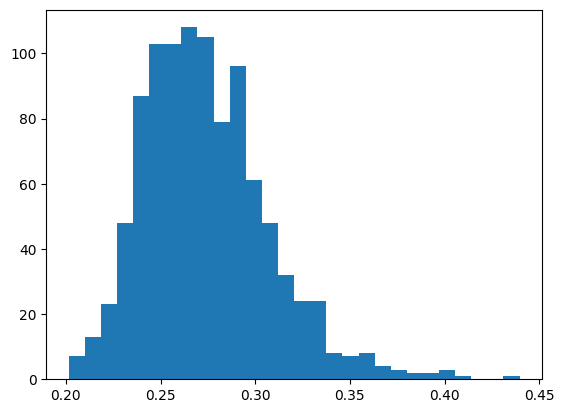

In [11]:
res = []
for i in range(1000):
  lnc = multivariate_lognormal_cascade(6, sigma1=0.2**0.5, sigma2=0.2**0.5, corr=.2)
  test = lnc.copy( )
  test[:,:,0] = test[:,:,0] * p0 * 100
  test[:,:,1] = test[:,:,1] * p1 * 100
  res.append(Theil(test))
plt.hist(res, bins='auto');

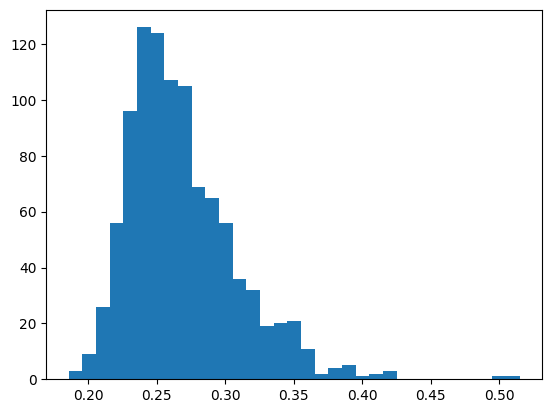

In [ ]:
res = []
for i in range(1000):
  lnc = multivariate_lognormal_cascade(6, sigma1=0.1**0.5, sigma2=0.8**0.5, corr=1)
  test = lnc.copy( )
  test[:,:,0] = test[:,:,0] * p0 * 100
  test[:,:,1] = test[:,:,1] * p1 * 100
  res.append(Theil(test))
plt.hist(res, bins='auto');

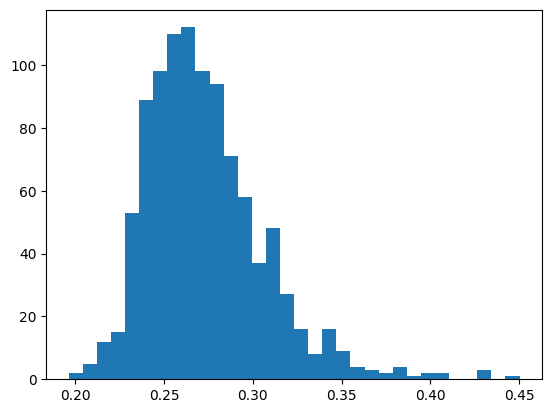

In [ ]:
plt.hist(res, bins='auto');

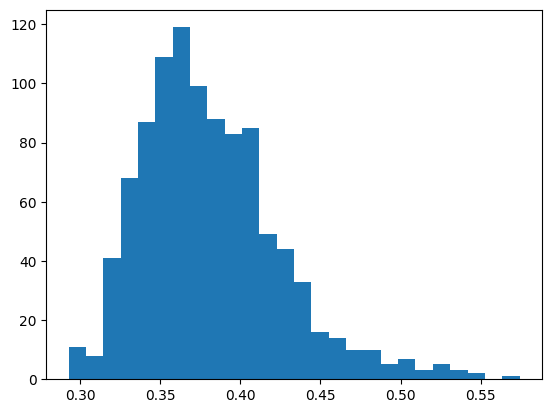

In [30]:
res = []
for i in range(1000):
  lnc = multivariate_lognormal_cascade(6, sigma1=0.2**0.5, sigma2=0.2**0.5, corr=-.2)
  test = lnc.copy( )
  test[:,:,0] = test[:,:,0] * p0 * 100
  test[:,:,1] = test[:,:,1] * p1 * 100
  res.append(Theil(test))
plt.hist(res, bins='auto');

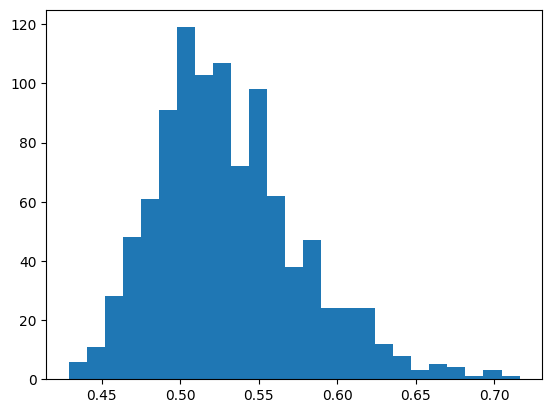

In [ ]:
res = []
for i in range(1000):
  lnc = multivariate_lognormal_cascade(6, sigma1=0.2**0.5, sigma2=0.2**0.5, corr=-.9)
  test = lnc.copy( )
  test[:,:,0] = test[:,:,0] * p0 * 100
  test[:,:,1] = test[:,:,1] * p1 * 100
  res.append(Theil(test))
plt.hist(res, bins='auto');

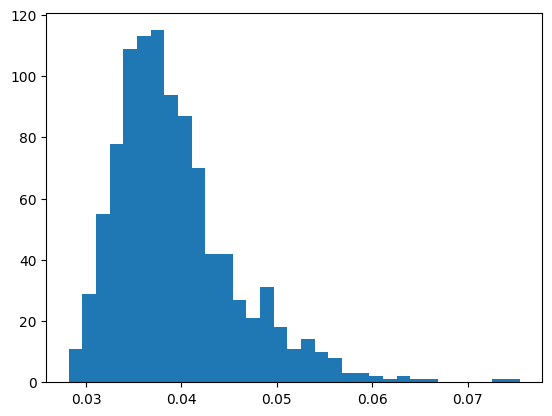

In [ ]:
res = []
for i in range(1000):
  lnc = multivariate_lognormal_cascade(6, sigma1=0.2**0.5, sigma2=0.2**0.5, corr=.9)
  test = lnc.copy( )
  test[:,:,0] = test[:,:,0] * p0 * 100
  test[:,:,1] = test[:,:,1] * p1 * 100
  res.append(Theil(test))
plt.hist(res, bins='auto');

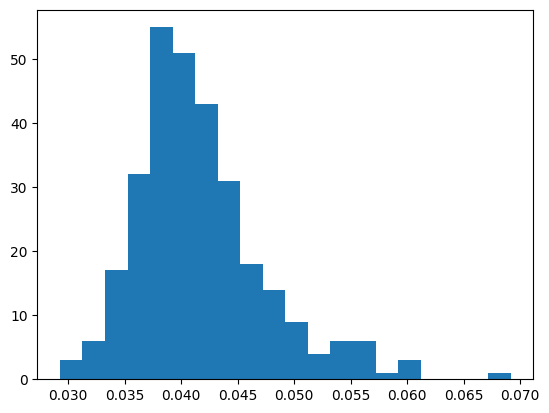

In [ ]:
res = []
for i in range(300):
  lnc = multivariate_lognormal_cascade(10, sigma1=0.2**0.5, sigma2=0.2**0.5, corr=.9)
  lnc = block_reduce(lnc, block_size = (16,16,1), func = np.sum)

  test = lnc.copy( )
  test[:,:,0] = test[:,:,0] * p0 * 100
  test[:,:,1] = test[:,:,1] * p1 * 100
  res.append(Theil(test))
plt.hist(res, bins='auto');

In [ ]:
lnc = multivariate_lognormal_cascade(10, sigma1=0.2**0.5, sigma2=0.2**0.5, corr=.9)
block_reduce(lnc, block_size = (16,16,1), func = np.sum).shape

(128, 128, 2)

### Theil multi échelle

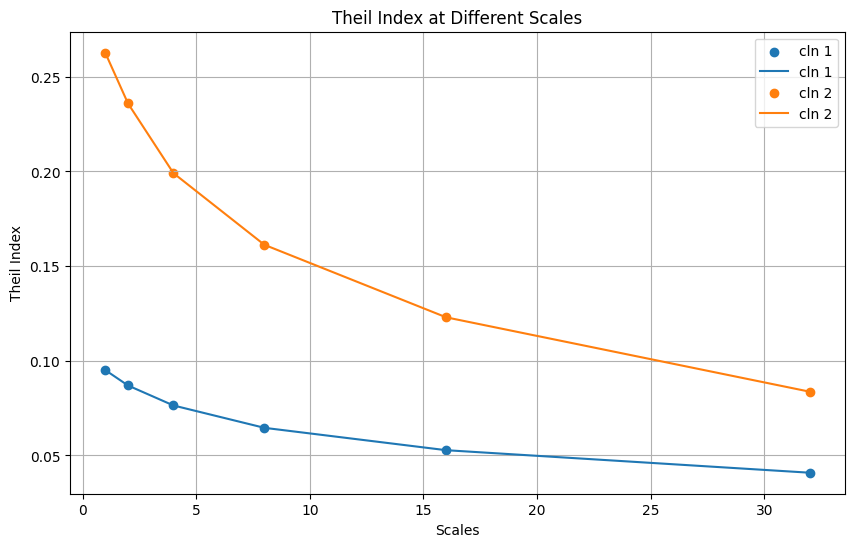

In [118]:
lnc = multivariate_lognormal_cascade(6, sigma1=0.1**0.5, sigma2=0.1**0.5, corr=.6)
test1 = lnc.copy( )
test1[:,:,0] = test1[:,:,0] * p0
test1[:,:,1] = test1[:,:,1] * p1

lnc = multivariate_lognormal_cascade(6, sigma1=0.1**0.5, sigma2=0.1**0.5, corr=-.6)
test2 = lnc.copy( )
test2[:,:,0] = test2[:,:,0] * p0
test2[:,:,1] = test2[:,:,1] * p1

scales = 2**np.array([i for i in range(0,6)])
theils1 = []
theils2 = []
for s in scales:
  small_arr1 = block_reduce(test1, block_size=(s,s,1), func=np.sum)
  theils1.append(Theil(small_arr1))
  small_arr2 = block_reduce(test2, block_size=(s,s,1), func=np.sum)
  theils2.append(Theil(small_arr2))

plt.figure(figsize=(10, 6))
#plt.xscale('log')
plt.scatter(scales, theils1, label='cln 1')
plt.plot(scales, theils1, label='cln 1')
plt.scatter(scales, theils2, label='cln 2')
plt.plot(scales, theils2, label='cln 2')

plt.xlabel('Scales')
plt.ylabel('Theil Index')
plt.title('Theil Index at Different Scales')
plt.legend()
plt.grid(True)
plt.show()

In [56]:
scales = 2**np.array([i for i in range(0,7)])
theils1 = []
theils2 = []
for s in scales:
  small_arr1 = block_reduce(test1, block_size=(s,s,1), func=np.sum)
  theils1.append(Theil(small_arr1))
  small_arr2 = block_reduce(test2, block_size=(s,s,1), func=np.sum)
  theils2.append(Theil(small_arr2))


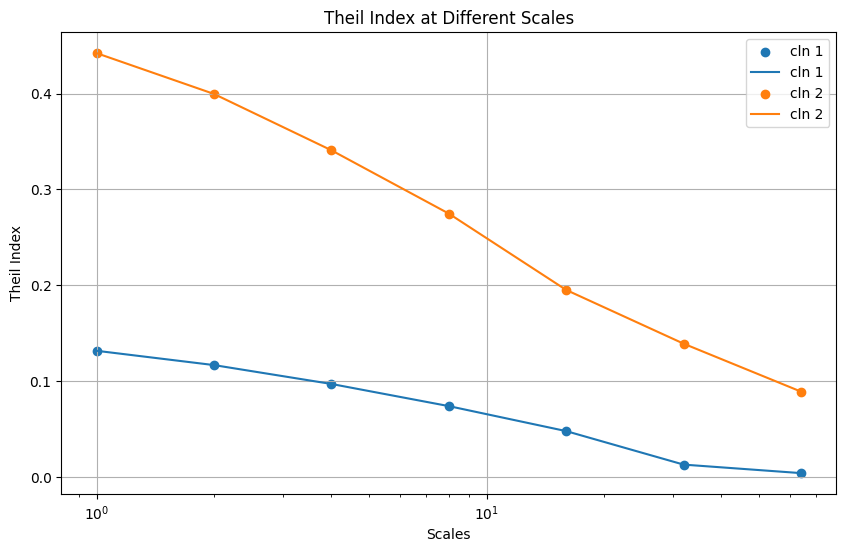

In [92]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
#plt.xscale('log')
#plt.yscale('log')

plt.scatter(scales, theils1, label='cln 1')
plt.plot(scales, theils1, label='cln 1')
plt.scatter(scales, theils2, label='cln 2')
plt.plot(scales, theils2, label='cln 2')

plt.xlabel('Scales')
plt.ylabel('Theil Index')
plt.title('Theil Index at Different Scales')
plt.legend()
plt.grid(True)
plt.show()

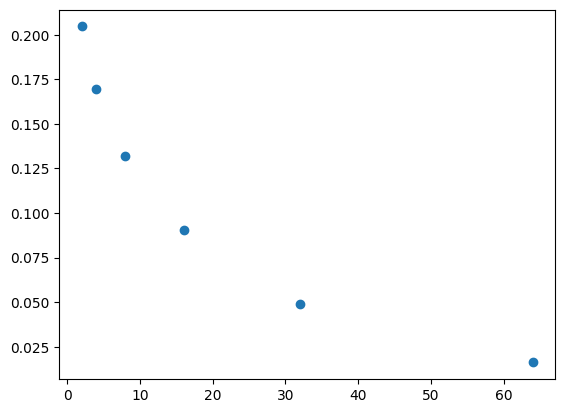

In [ ]:
plt.scatter(scales,theils)

In [ ]:
t[:,:, np.newaxis]

array([[[9.78791047e-06],
        [1.50176399e-05],
        [1.26316326e-05],
        ...,
        [1.35549318e-05],
        [1.72112279e-05],
        [1.71400439e-05]],

       [[1.32123208e-05],
        [8.95336681e-06],
        [4.73459140e-06],
        ...,
        [1.36039405e-05],
        [8.09529332e-06],
        [1.24594840e-05]],

       [[1.40536476e-05],
        [1.87568486e-05],
        [1.66056685e-05],
        ...,
        [1.26232337e-05],
        [1.04575850e-05],
        [1.49851063e-05]],

       ...,

       [[1.22595550e-05],
        [1.52965682e-05],
        [7.93673193e-06],
        ...,
        [3.03585561e-05],
        [4.71359978e-05],
        [3.31009820e-05]],

       [[1.08283162e-05],
        [1.03888571e-05],
        [2.82405486e-06],
        ...,
        [1.80673475e-05],
        [4.64667604e-05],
        [5.81465651e-05]],

       [[1.01762358e-05],
        [1.31523199e-05],
        [6.73553901e-06],
        ...,
        [2.46560192e-05],
        [6.8999

## Duncan Segregation Index

In [28]:
def Duncan(pop_array):
  prob_array = pop_array / pop_array.sum(axis=(0,1))
  return(1/2 * np.abs(prob_array[:,:,0] - prob_array[:,:,1]).sum())

In [29]:
Duncan(paris)

np.float64(0.2517930664245248)

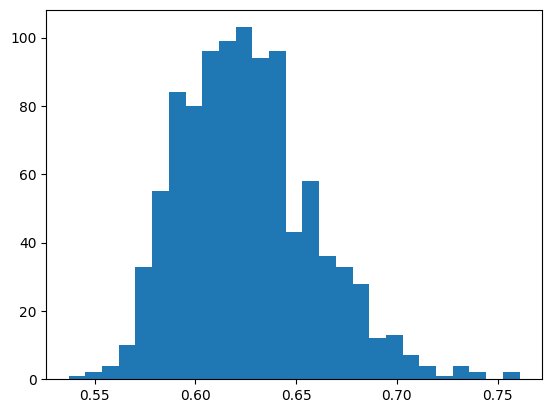

In [32]:
res = []
for i in range(1000):
  lnc = multivariate_lognormal_cascade(6, sigma1=0.2**0.5, sigma2=0.2**0.5, corr=-.2)
  res.append(Duncan(lnc))
plt.hist(res, bins='auto');

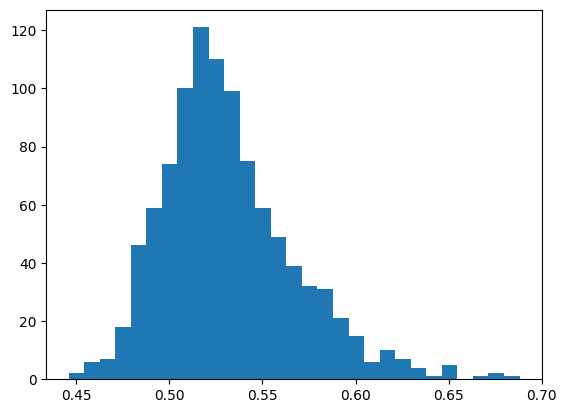

In [35]:
res = []
for i in range(1000):
  lnc = multivariate_lognormal_cascade(6, sigma1=0.2**0.5, sigma2=0.2**0.5, corr=.2)
  res.append(Duncan(lnc))
plt.hist(res, bins='auto');

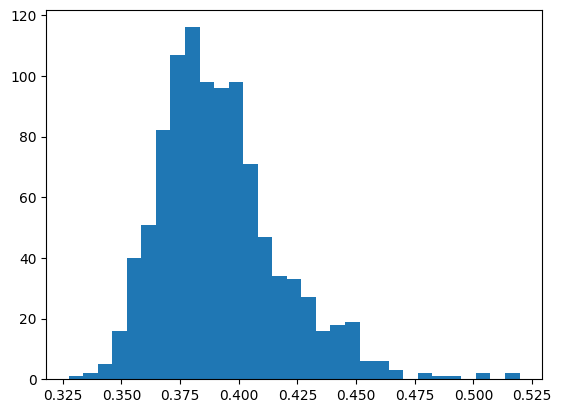

In [36]:
res = []
for i in range(1000):
  lnc = multivariate_lognormal_cascade(6, sigma1=0.1**0.5, sigma2=0.1**0.5, corr=.2)
  res.append(Duncan(lnc))
plt.hist(res, bins='auto');

Multiechelle

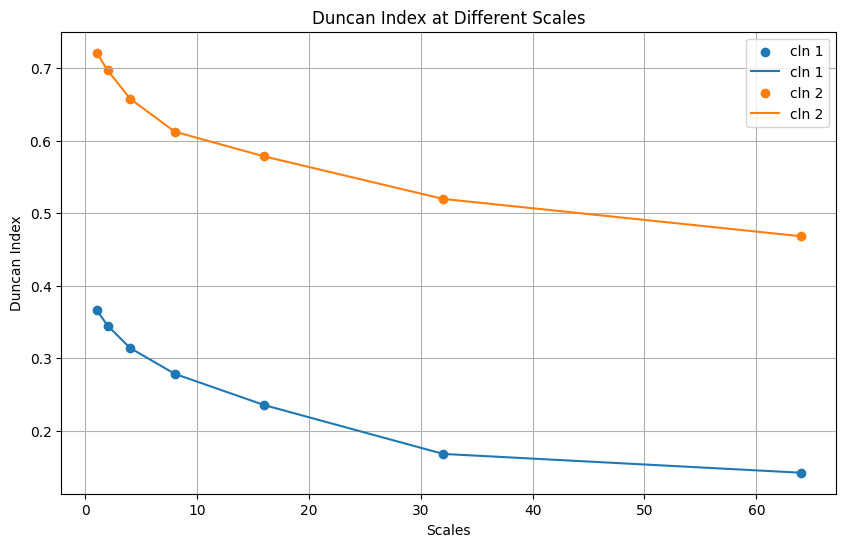

In [80]:
test1 = multivariate_lognormal_cascade(6, sigma1=0.2**0.5, sigma2=0.2**0.5, corr=.6)
test2 = multivariate_lognormal_cascade(6, sigma1=0.2**0.5, sigma2=0.2**0.5, corr=-.6)

scales = 2**np.array([i for i in range(0,7)])
Duncans1 = []
Duncans2 = []
for s in scales:
  small_arr1 = block_reduce(test1, block_size=(s,s,1), func=np.sum)
  Duncans1.append(Duncan(small_arr1))
  small_arr2 = block_reduce(test2, block_size=(s,s,1), func=np.sum)
  Duncans2.append(Duncan(small_arr2))

plt.figure(figsize=(10, 6))
plt.scatter(scales, Duncans1, label='cln 1')
plt.plot(scales, Duncans1, label='cln 1')
plt.scatter(scales, Duncans2, label='cln 2')
plt.plot(scales, Duncans2, label='cln 2')

plt.xlabel('Scales')
plt.ylabel('Duncan Index')
plt.title('Duncan Index at Different Scales')
plt.legend()
plt.grid(True)
plt.show()

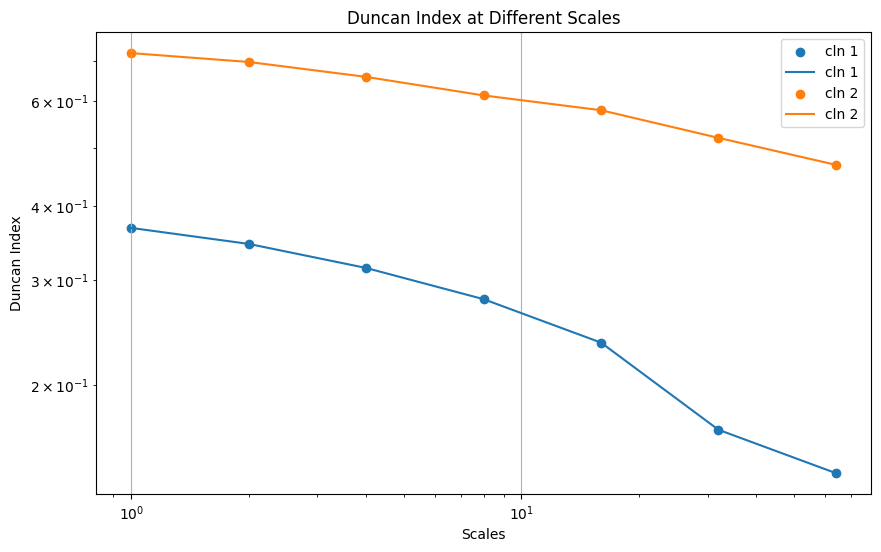

In [87]:
plt.figure(figsize=(10, 6))
plt.xscale('log')
plt.yscale('log')

plt.scatter(scales, Duncans1, label='cln 1')

plt.plot(scales, Duncans1, label='cln 1')
plt.scatter(scales, Duncans2, label='cln 2')
plt.plot(scales, Duncans2, label='cln 2')

plt.xlabel('Scales')
plt.ylabel('Duncan Index')
plt.title('Duncan Index at Different Scales')
plt.legend()
plt.grid(True)
plt.show()

